In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("/home/alirachidi/doordash/prediction")
import numpy as np
np.set_printoptions(precision = 4)
np.set_printoptions(suppress=True)
from modules.main.processing import *
from modules.main.analysis import *
from modules.main import parameters as p
# %matplotlib inline


In [20]:
!pwd
p.init({'debugging': '0', 'description': 'test'}, "data_analysis")
p.decision_features += p.time_features
p.decision_features += p.domain_features


/home/alirachidi/doordash/prediction/jobs
-- Collecting Variables... --
Tensorflow Version: 2.7.0
Num GPUs Available:  0
PID: 10513
Description: test
File dir is /home/alirachidi/doordash/prediction/cache/data_analysis
--- All variables have been collected. --


In [21]:
# cache_root = "../../prediction/cache/"
# data_root = "../../data/"

historical_data = pd.read_csv(os.path.join(p.data_root, "_historical_data.csv"))
df_test = pd.read_csv(os.path.join(p.data_root, "_predict_data.csv"))
categorical_columns = ['store_id', 'market_id', 'week_day',
                       'hour', 'month', 'weekend', 'day_part', 'day_of_month']
numerical_columns = ['subtotal', 'total_onshift_dashers',
                     'total_busy_dashers', 'total_outstanding_orders',
                     'estimated_store_to_consumer_driving_duration', 'delivery_duration_sec']


In [22]:
df = historical_data # change this to run analysis on historical or test data
curr_label = "historical_" # values: "test_", "historical_data_"
df.head()

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441,33.0,14.0,21.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900,1.0,2.0,2.0,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1900,1.0,0.0,0.0,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,6900,1.0,1.0,2.0,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,3900,6.0,6.0,9.0,650.0


In [23]:
print(historical_data.shape)
print("beg")
print(historical_data['created_at'].sort_values(ascending=True).head())
print("end")
print(historical_data['created_at'].sort_values(ascending=True).tail())

(197428, 9)
beg
2690      2014-10-19 05:24:15
43519     2015-01-21 15:22:03
148754    2015-01-21 15:31:51
187014    2015-01-21 15:39:16
10265     2015-01-21 15:40:42
Name: created_at, dtype: object
end
176616    2015-02-18 05:57:51
100474    2015-02-18 05:58:07
191692    2015-02-18 05:59:01
168114    2015-02-18 05:59:23
61787     2015-02-18 06:00:44
Name: created_at, dtype: object


In [24]:
print(df_test.shape)
print("beg")
print(df_test['created_at'].sort_values(ascending=True).head())
print("end")
print(df_test['created_at'].sort_values(ascending=True).tail())

(54778, 9)
beg
27577    2015-02-18 14:50:28
50927    2015-02-18 14:59:26
47372    2015-02-18 15:04:22
22766    2015-02-18 15:13:50
1385     2015-02-18 15:22:38
Name: created_at, dtype: object
end
6743     2015-02-25 05:58:32
52619    2015-02-25 05:58:56
30709    2015-02-25 05:59:35
38205    2015-02-25 05:59:41
34166    2015-02-25 05:59:49
Name: created_at, dtype: object


# processing timestamps

In [25]:
names = ['created_at']


if 'actual_delivery_time' in df.columns:
    names += ['actual_delivery_time']

process_timestamps(df, names)    
if 'actual_delivery_time' in df.columns:
    df['delivery_duration_sec'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()

# cleaning data

In [26]:
print("pre: {}".format(df.shape))
df.isnull().sum().sum() # number of null elements

pre: (197428, 10)


50313

In [27]:
temp = df
temp.drop(names, axis=1).lt(0).sum().sum() # number of elements less than 0 as all variables are meant to be positive

86

In [28]:
df = clean_data(
    df, ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders'])


In [29]:
df.isnull().sum().sum()

0

In [30]:
df.drop(names, axis=1).lt(0).sum().sum()


0

In [31]:
df = remove_outliers(df)

There is a decent amount of outliers in delivery_duration_sec in historical dataset

Test set loses about 5k elements <br>
Historical set loses 50k <br>
I realized a bit late how many samples in test are lost, and reflecting on it, 50k is too much historical. I must implement a strategy to complete those samples, for another time!

# Adding New Features

In [32]:
from modules.main.feature_engineering import *
p.feature_writing = False
p.feature_version = "_v4"
df = add_features(df, label=curr_label)
# note: current file writing happens before removing outliers, so one must include outliers when reading file for matching elements/dimensions

--- Reading /home/alirachidi/doordash/data/historical_market_id_features_v4.csv...
--- Reading /home/alirachidi/doordash/data/historical_store_id_features_v4.csv...


# Categorical Data Analysis

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id', 'subtotal', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_store_to_consumer_driving_duration', 'delivery_duration_sec', 'week_day', 'weekend', 'day_of_month', 'month', 'hour', 'day_part', '1_hr_count_by_market_id', '1_hr_avg_subtotal_by_market_id', '24_hr_avg_time_by_market_id', 'long_score_by_market_id', 'short_score_by_market_id', 'trip_to_customer_by_market_id', '1_hr_count_by_store_id', '1_hr_avg_subtotal_by_store_id', '24_hr_avg_time_by_store_id', 'long_score_by_store_id', 'short_score_by_store_id', 'trip_to_customer_by_store_id'], dtype='object')
6865    928
1311    852
314     810
1686    758
3937    718
       ... 
2067      1
2072      1
2078      1
4103      1
5637      1
Name: store_id, Length: 5786, dtype: int64
2.0    54600
4.0    47213
1.0    37657
3.0    21582
5.0    17851
6.0      652
Name: market_id, dtype: int64
5    31520
6    30588
4    25554
0    24694
3   

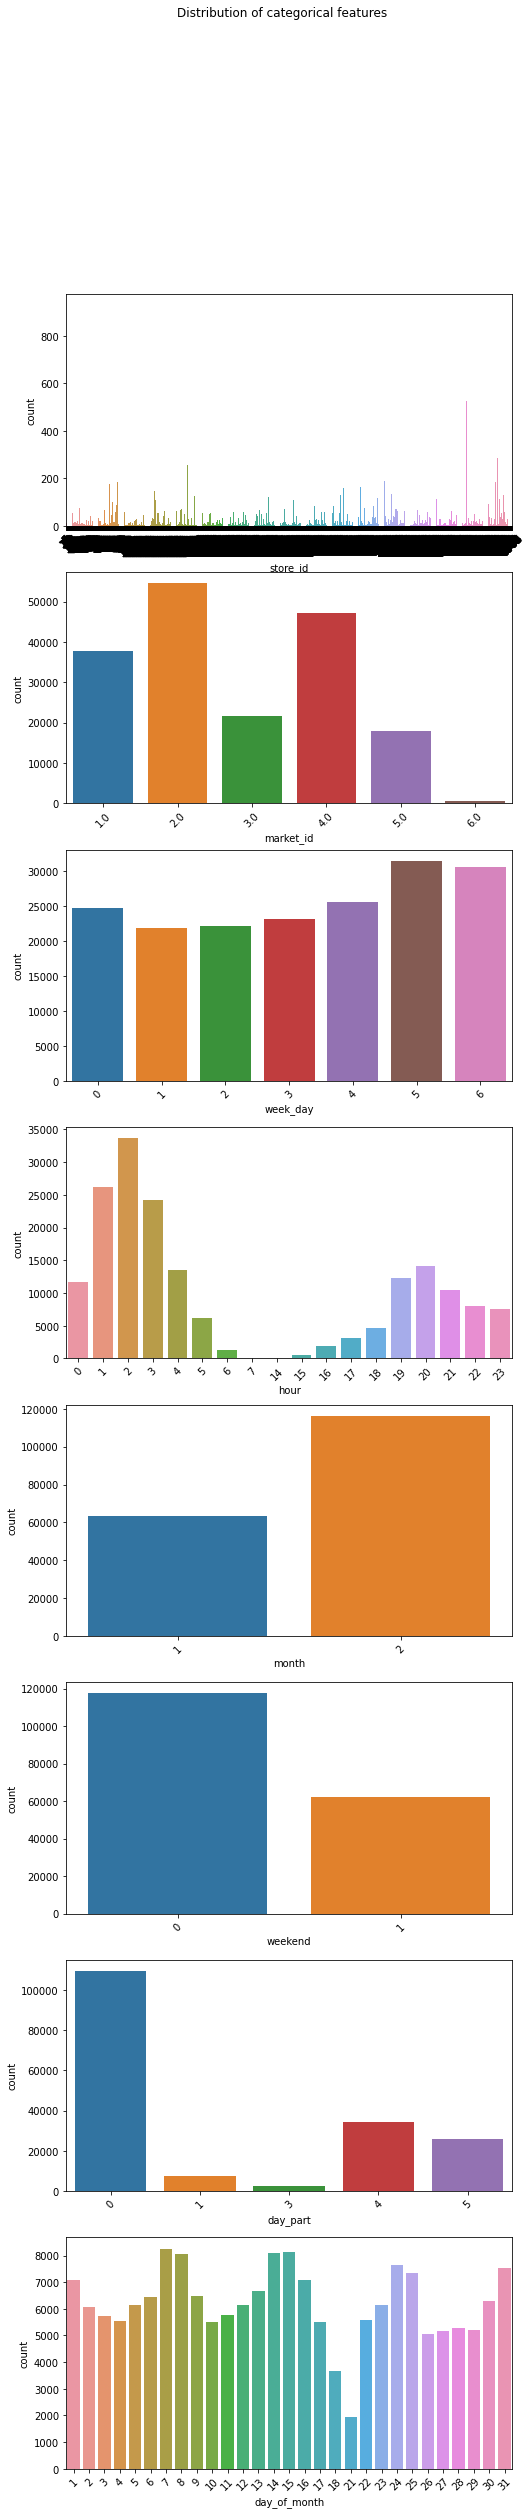

In [33]:
print(df.columns)

plot_categorical_columns(df, categorical_columns)


Observations:

most orders happen at night; more on weekends; some stores only have 1 orders while other up to 800<br>
varying market sizes, with very small market 6, which could be impactful <br>
variables are well distributed so there is a lot of substance to work with<br>
the distribution of time variables indicate trends and could play a large role in prediction, both with the variables in themselves but also introducing temporal trends and data engineering <br>
market_id and store_id have enough variability between and amongst them that we can try to exploit<br>

# Numerical data analysis

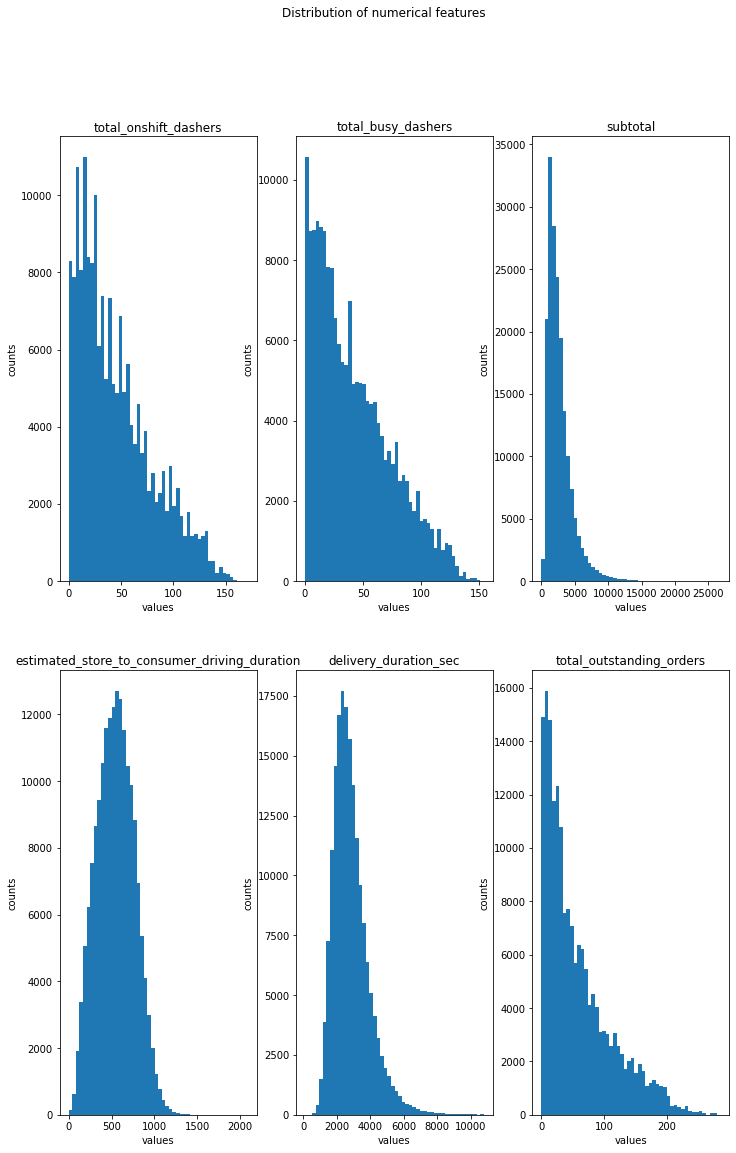

In [34]:
plot_numerical_columns(df, numerical_columns)

notice the uneven distributions, or long-tail distributions, across all variables

<AxesSubplot:>

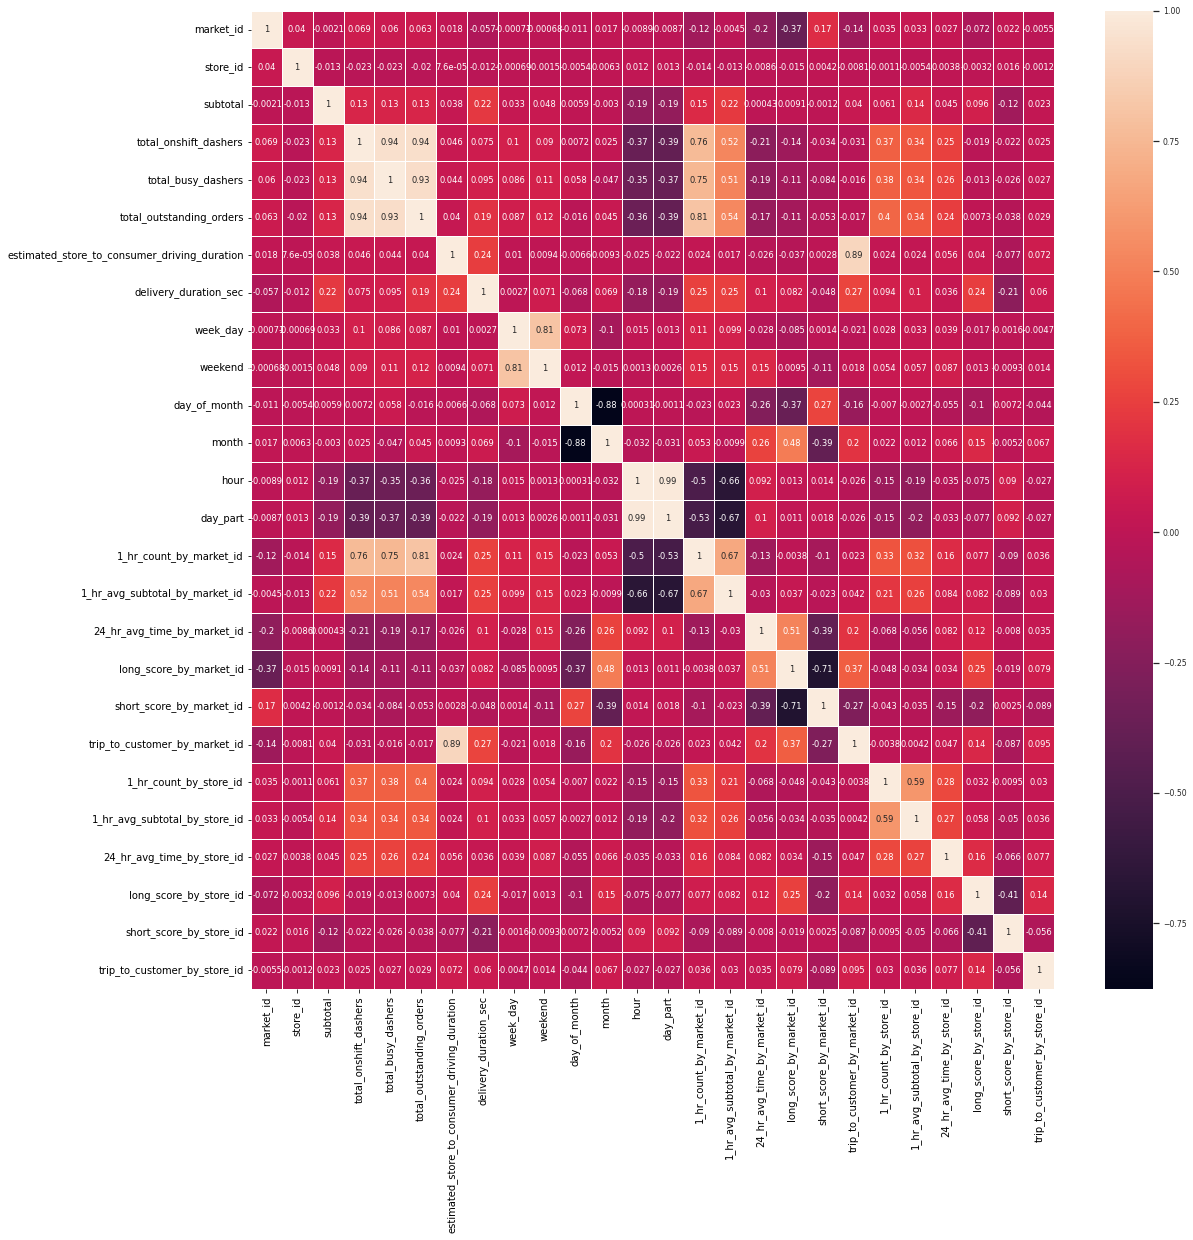

In [35]:
fig, ax = plt.subplots(figsize=(18,18))         # Sample figsize in inches
sns.set(font_scale=0.7)

sns.heatmap(df.corr(), annot=True, linewidths=.5, ax=ax, fmt='.2g')

# New Feature + Domain Analysis

/home/alirachidi/anaconda3/envs/classification/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


1_hr_count_by_market_id
value count for value=0 for 1_hr_count_by_market_id: 263
1_hr_count_by_market_id
57                         988
58                         968
69                         947
56                         940
60                         926
67                         926
54                         920
66                         914
70                         913
55                         912
dtype: int64
1_hr_count_by_market_id
57                         0.005502
58                         0.005391
69                         0.005274
56                         0.005235
60                         0.005157
67                         0.005157
54                         0.005124
66                         0.005090
70                         0.005085
55                         0.005079
dtype: float64
_____________________________
1_hr_count_by_store_id
value count for value=0 for 1_hr_count_by_store_id: 112322
1_hr_count_by_store_id
0                         112322
1    

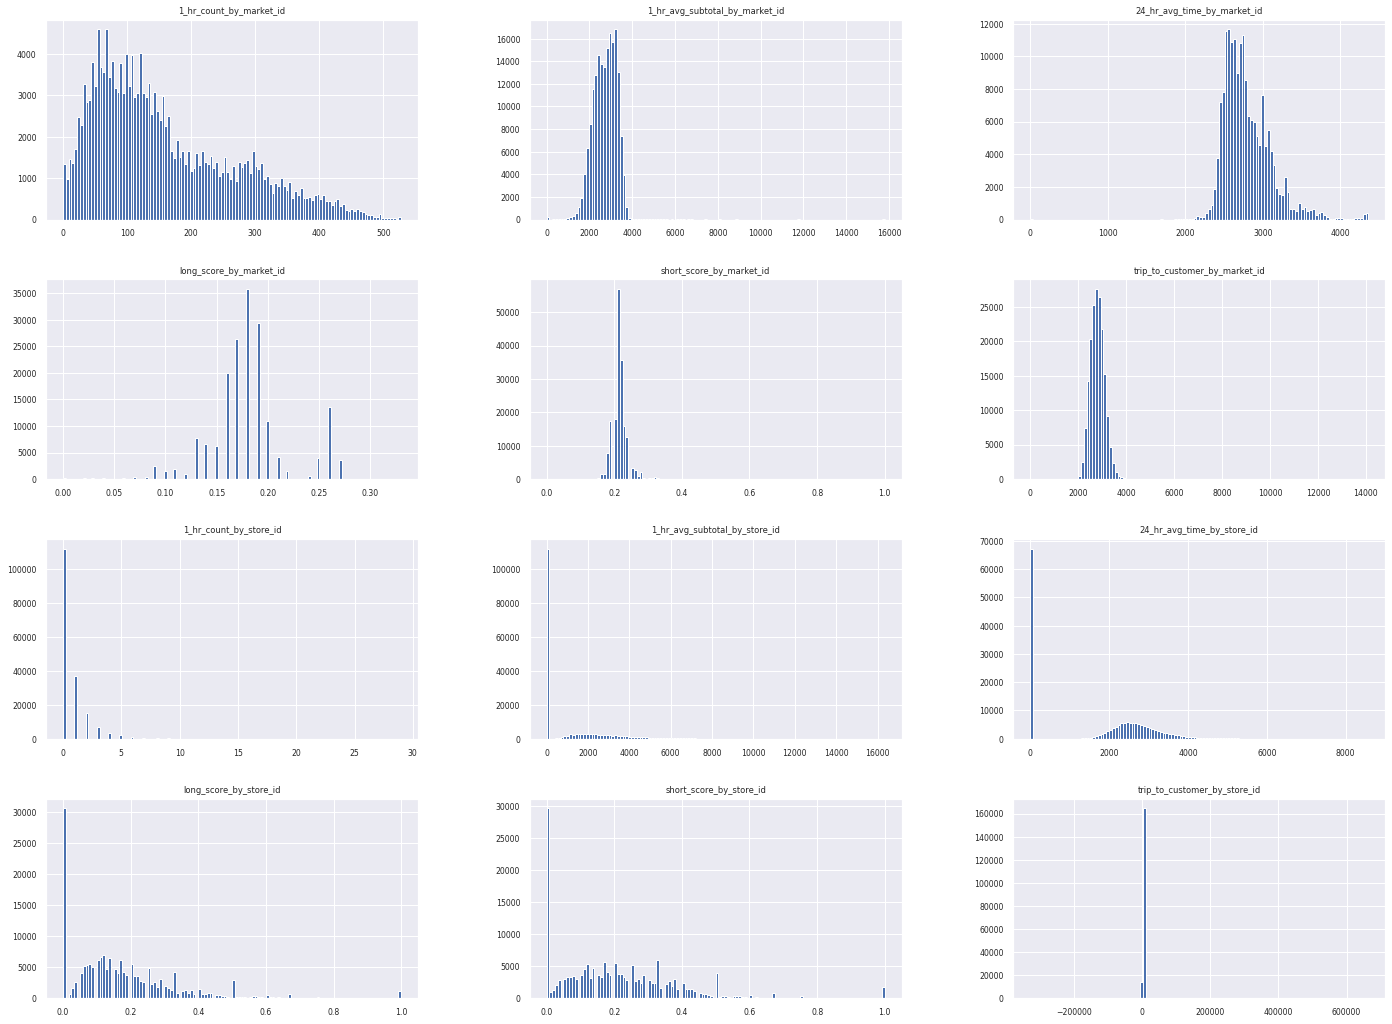

In [36]:
# distribution and sparsity of new features
fig = plt.figure(figsize=(24, 18))
ax = fig.gca()
fig.suptitle('Distribution of crafted features')

df.hist(column=df.columns.intersection(p.domain_features), ax=ax, bins=120)

for c in p.domain_features:
    print(c)
    if not (c in df.columns):
        print("omitted {}".format(c))
        continue
    d = df[[c]].value_counts()
    if 0 in d.keys():
        print("value count for value=0 for {}: {}".format(c, d[0]))
    print(d.nlargest(10))
    print(d.nlargest(10)/df.shape[0])
    print("_____________________________")


Note on feature generating under constrain of missing features and search inside another space (i.e., search historical to generate features for test):
In the test data, count and avg_subtotal are generated from within test data (e.g., the same search space), while long_score, short_score and trip_to_customer are generated from a difference search space, the historical data due to unavailable time labels in test data. <br>
Therefore, the long scores, short scores and linear regression parameters that generate trip_to_consumer will be the same throughout the test data, acting as historical fixed features. <br> 
In other words, there should be as many long_score_by_market_id and short_score_by_market_id unique values as there are markets, 6! (Same for store ids) <br>
It is the case! Only, market id 2 and 5 share the same short_score_by_market_id, 0.21. <br>
Similarly, market id 3, 4 and 6 share the same short_score_by_market_id, 0.2, and while markets also share 4 unique long_score_by_market_id

observations: <br>
the distributions of new feature seem good and could provide a lot of information. <br>
Only 1 hour count by store id, and logically, 1 hr average by store id, seem to be suffer from sparsity with 60% of 0 values. Nonetheless, they still have the potential of being useful. <br>
Some of these features seem to have a long tail distribution as well, possibly having the potential of detecting a long-tail order. <br>
trip to customer seems to be informative by market id than store id (per correlation heat map), which makes sense because distances will be more conform across a market than store. <br>
long/short scores form a more compact distribution in the market domain in the 0.1-0.3 range, while store feature are sparse can go up to 0.5. <br>
Overall, market_id features are not sparse while store_id features are more so. Nonetheless, both are rich in information. Domains complete each others quite well as some features seem more suitable for store while others more for market. <br>

threshold for long tail: 0.7 percentile, 3200.0, or 53.333333333333336 minutes
threshold for short tail: 0.3 percentile, 2218.0 or 36.96666666666667 minutes
--------
name: market_id_1.0
n_elements: 37657
long: 0.3751759301059564
short: 0.26619220861991133
--------
name: market_id_2.0
n_elements: 54600
long: 0.2631868131868132
short: 0.3142857142857143
--------
name: market_id_3.0
n_elements: 21582
long: 0.28968584931887686
short: 0.30784913353720694
--------
name: market_id_4.0
n_elements: 47213
long: 0.29765107067968566
short: 0.30154830237434604
--------
name: market_id_5.0
n_elements: 17851
long: 0.27656713909584896
short: 0.31751722592571846
--------
name: market_id_6.0
n_elements: 652
long: 0.30368098159509205
short: 0.28067484662576686
--------
name: store_id_1
n_elements: 8
long: 0.125
short: 0.25
--------
name: store_id_2
n_elements: 5
long: 0.0
short: 0.6
--------
name: store_id_3
n_elements: 3
long: 0.0
short: 0.3333333333333333
--------
name: store_id_4
n_elements: 134
long:

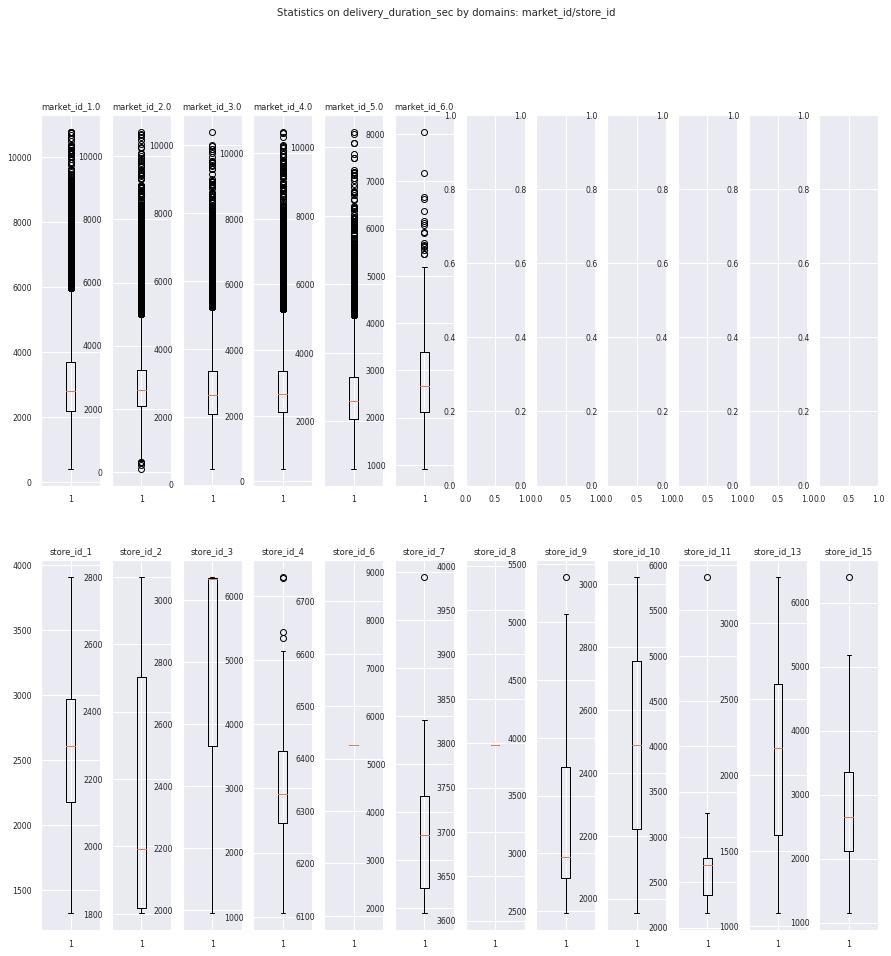

In [37]:
# are certain markets or stores more prone to short/long tail orders?
if 'delivery_duration_sec' in df.columns:
    upper_threshold = df['delivery_duration_sec'].quantile(0.70)
    lower_threshold = df['delivery_duration_sec'].quantile(0.30)
    print("threshold for long tail: {} percentile, {}, or {} minutes".format(0.70, upper_threshold, upper_threshold/60))
    print("threshold for short tail: {} percentile, {} or {} minutes".format(0.30, lower_threshold, lower_threshold/60))
    fig, axs = plt.subplots(2, 12, figsize=(15, 15))
    fig.suptitle('Statistics on delivery_duration_sec by domains: market_id/store_id')

    for i, col in enumerate(['market_id', 'store_id']):
        for y, v in enumerate(sorted(df[col].unique())[:12]):
            name = "{}_{}".format(col, v)
            print("--------")
            print("name: {}".format(name))
            domain_df = df.loc[df[col] == v]
            n_el = len(domain_df)
            axs[i,y].boxplot(domain_df['delivery_duration_sec'])
            axs[i,y].set_title(name)
            long_tails = domain_df.loc[domain_df['delivery_duration_sec'] >= upper_threshold]
            short_tails = domain_df.loc[domain_df['delivery_duration_sec'] <= lower_threshold]
            print("n_elements: {}".format(n_el))
            print("long: {}".format(len(long_tails)/len(domain_df)))
            print("short: {}".format(len(short_tails)/len(domain_df)))


observations: again, another experiment that shows a lots of variability. some market and stores could be more prone to long/short tail orders, which could cause our predictor to be too early or late. <br>
The dataset already has a lot of variability across features, but what about across time? <br>

# Time

observation: 
markets and store seen trends across large chunks of time that can be exploited. Options are: <br>
a) Time-representative features, as we've already seen with weekend(bool), hour(0-23) or part of a day(0-5) for example; <br>
b) time-series crafted features, which are features that seek for informative patterns about a sample over time, such as the average subtotal over the last 24 hours at a given store; <br> 
c) dynamic time-series crafted features, which consists of stacking multiple samples together to exploit information across them for a single sample. Example: an input with 5 stacks labelled with the current order and the previous 4 orders before (if any) <br>
- with the latter, we must validate the data on sequential data it has never seen, thereore splits must be sequential, not random. It is a good fit for our test data, which consists of the few weeks after the train data, and a real-time system application
- - example: train on the first 80% and validate on the last 20%
- - example: train on last 80% and validate on the first 20%

In [38]:
batch_one = ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']
batch_two = ['week_day', 'weekend', 'day_of_month', 'month', 'hour', 'day_part']
batch_three = ['long_score_by_market_id', 'short_score_by_market_id',
             'long_score_by_store_id', 'short_score_by_store_id']
batch_four = ['subtotal', '1_hr_avg_subtotal_by_market_id',  '1_hr_avg_subtotal_by_store_id']
batch_five = ['1_hr_count_by_market_id', '1_hr_count_by_store_id'
               ]
batch_six = ['estimated_store_to_consumer_driving_duration']
if '24_hr_avg_time_by_store_id' in df.columns:
    batch_six += ['24_hr_avg_time_by_store_id']
    batch_six += ['24_hr_avg_time_by_market_id']
if 'delivery_duration_sec' in df.columns:
    batch_six += ['delivery_duration_sec']
batches = [batch_one, batch_two, batch_three, batch_four, batch_five, batch_six]
    

In [39]:
from modules.main.helpers import *

6
New Domain: 0
start of slice 0: 2015-01-21 15:22:03
start of slice 1: 2015-01-21 16:30:05
start of slice 2: 2015-01-21 17:07:52
start of slice 3: 2015-01-21 17:28:03
start of slice 4: 2015-01-21 17:50:06
New Domain: 1
start of slice 0: 2015-01-21 15:54:48
start of slice 1: 2015-01-21 16:28:59
start of slice 2: 2015-01-21 17:00:58
start of slice 3: 2015-01-21 17:31:55
start of slice 4: 2015-01-21 17:55:13
New Domain: 2
start of slice 0: 2015-01-21 15:31:51
start of slice 1: 2015-01-21 17:05:45
start of slice 2: 2015-01-21 17:36:39
start of slice 3: 2015-01-21 18:05:58
start of slice 4: 2015-01-21 18:38:59
New Domain: 3
start of slice 0: 2015-01-21 16:07:57
start of slice 1: 2015-01-21 17:01:09
start of slice 2: 2015-01-21 17:45:53
start of slice 3: 2015-01-21 18:14:45
start of slice 4: 2015-01-21 18:40:56
New Domain: 4
start of slice 0: 2015-01-21 16:59:39


/home/alirachidi/anaconda3/envs/classification/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


start of slice 1: 2015-01-21 18:27:19
start of slice 2: 2015-01-21 19:11:38
start of slice 3: 2015-01-21 19:34:19
start of slice 4: 2015-01-21 20:01:47
New Domain: 5
start of slice 0: 2015-01-21 17:42:50
start of slice 1: 2015-01-22 01:54:57
start of slice 2: 2015-01-22 05:27:06
start of slice 3: 2015-01-23 01:37:53
start of slice 4: 2015-01-23 04:15:04


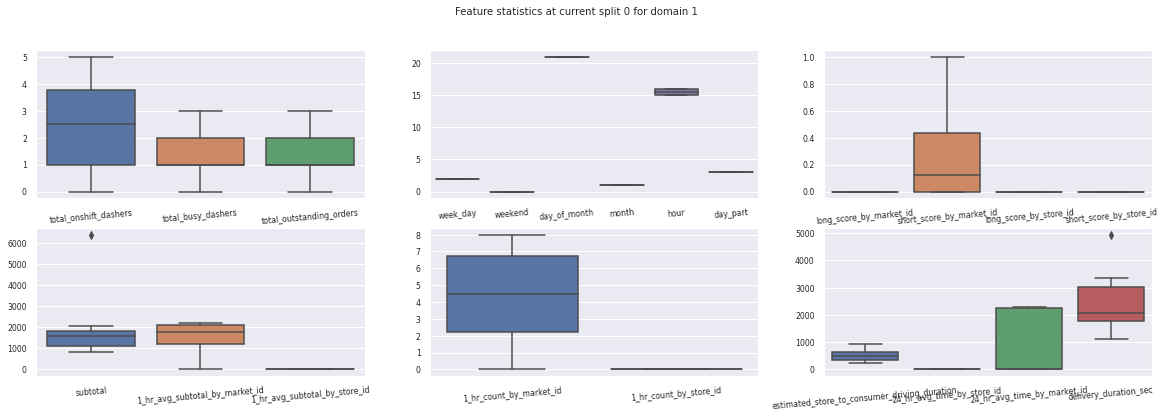

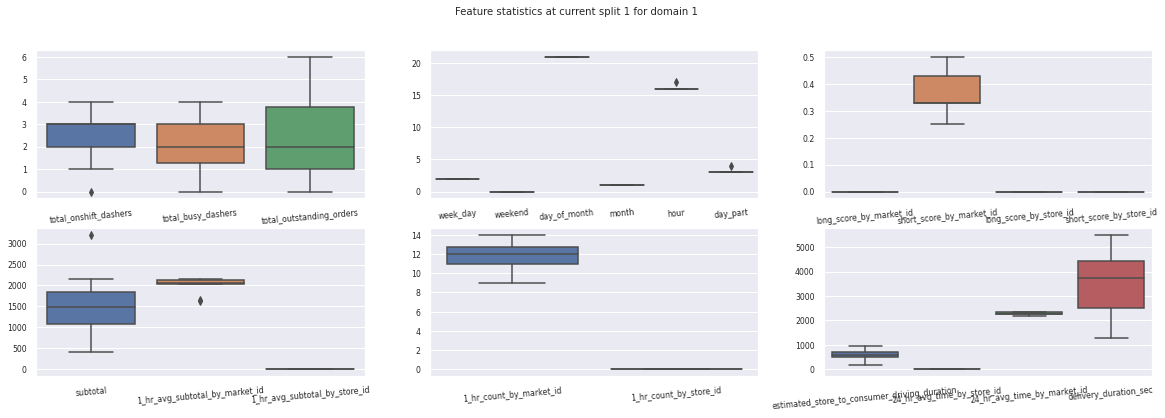

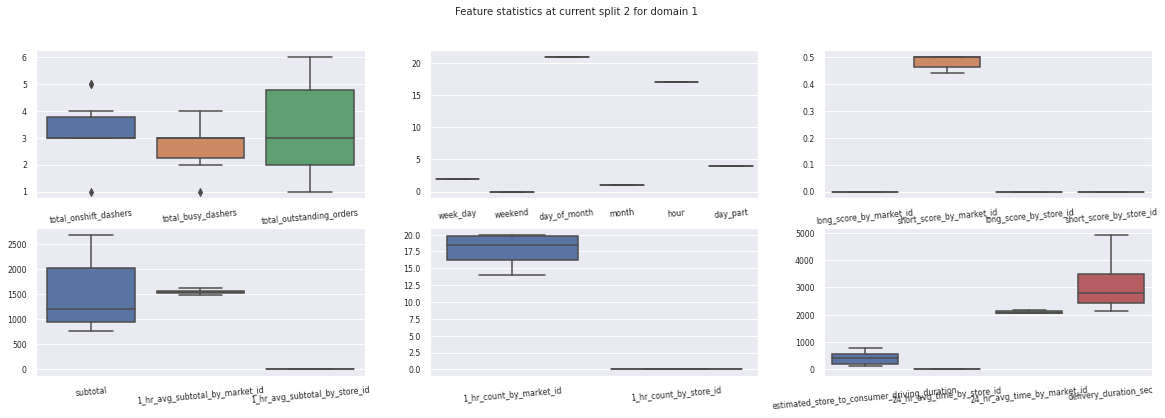

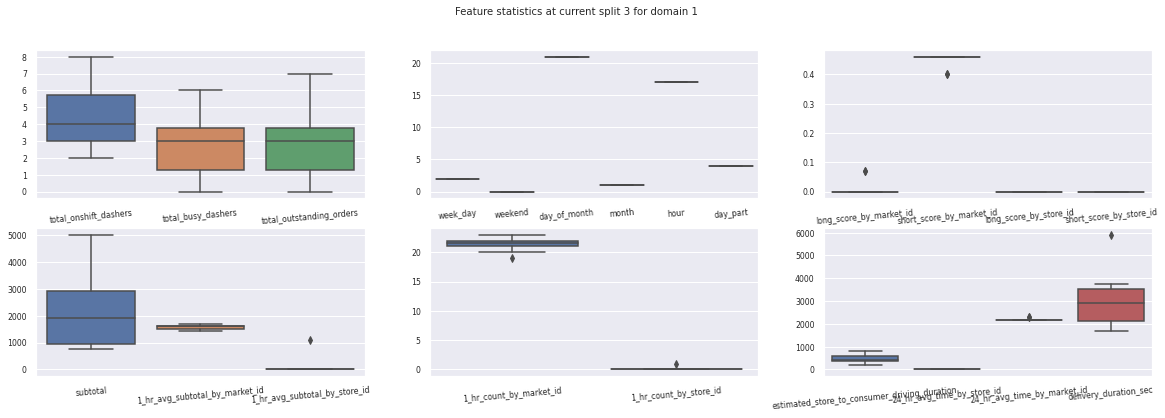

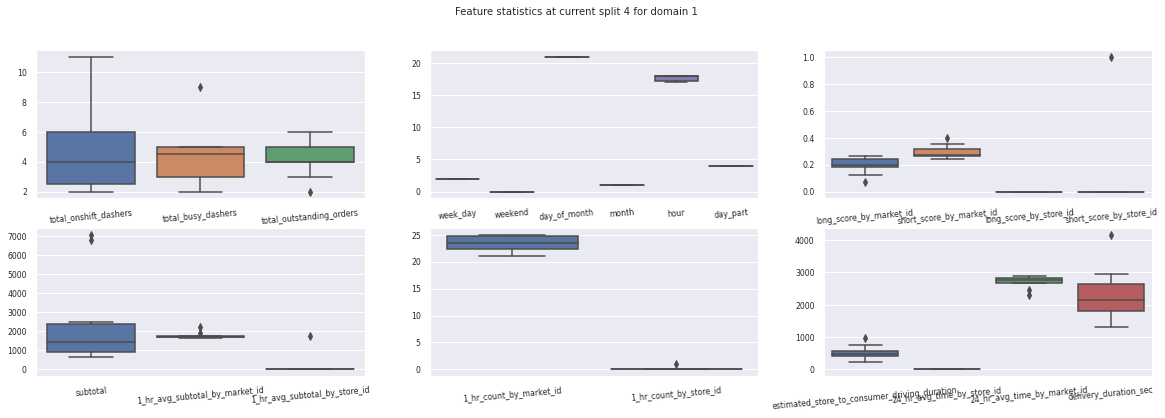

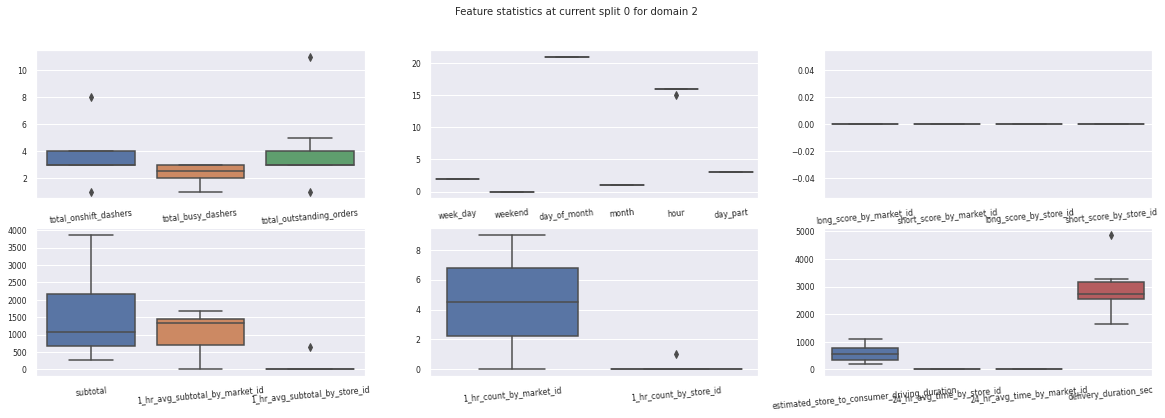

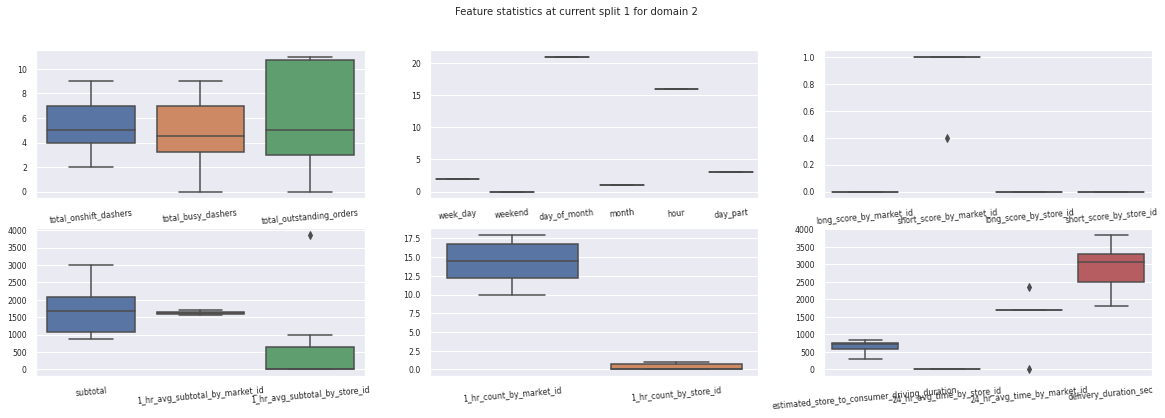

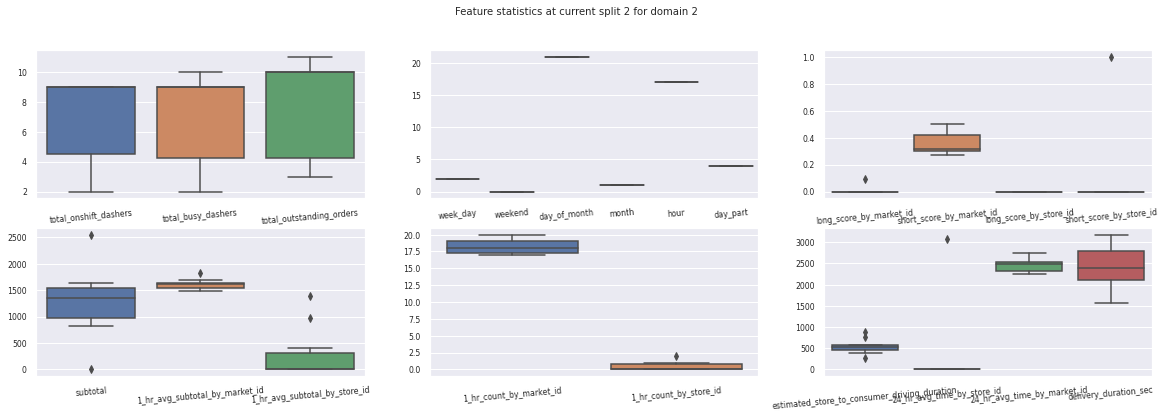

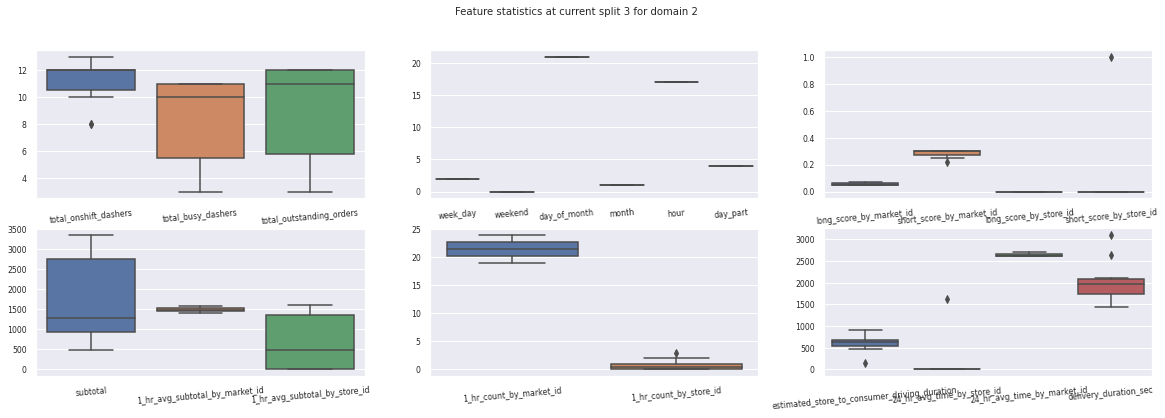

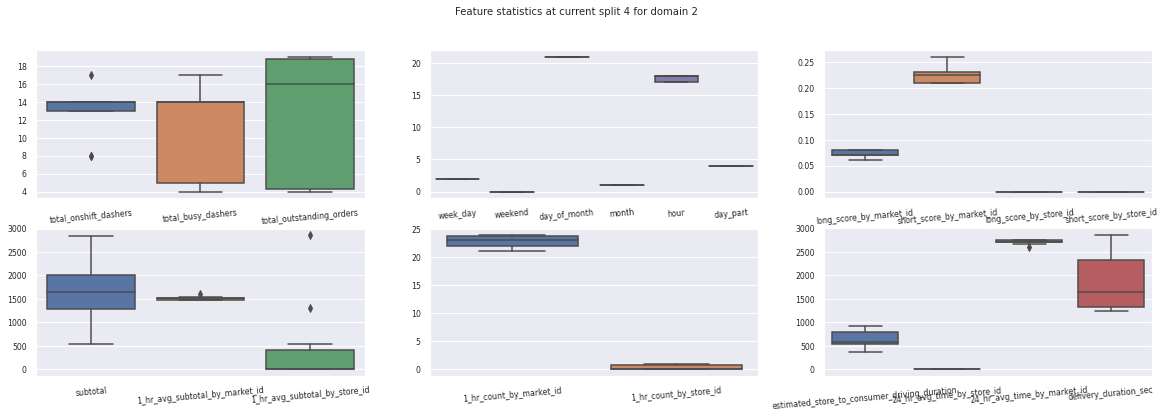

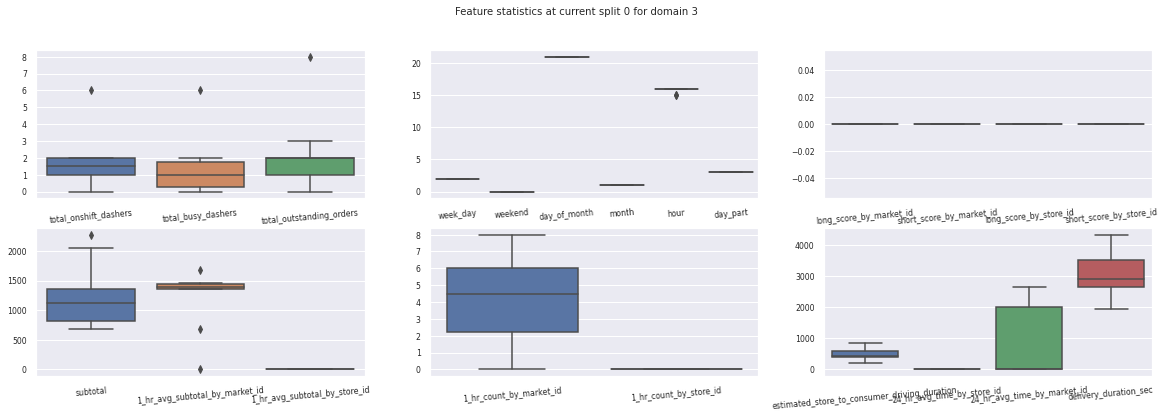

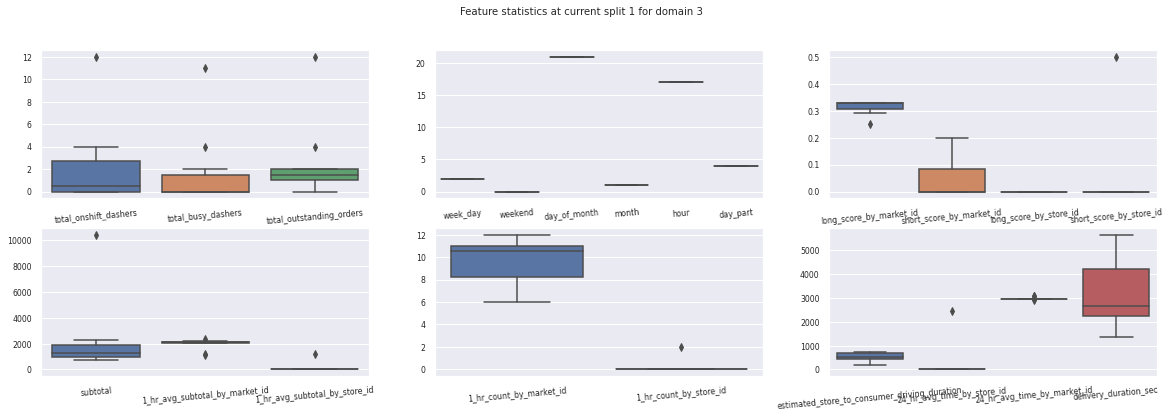

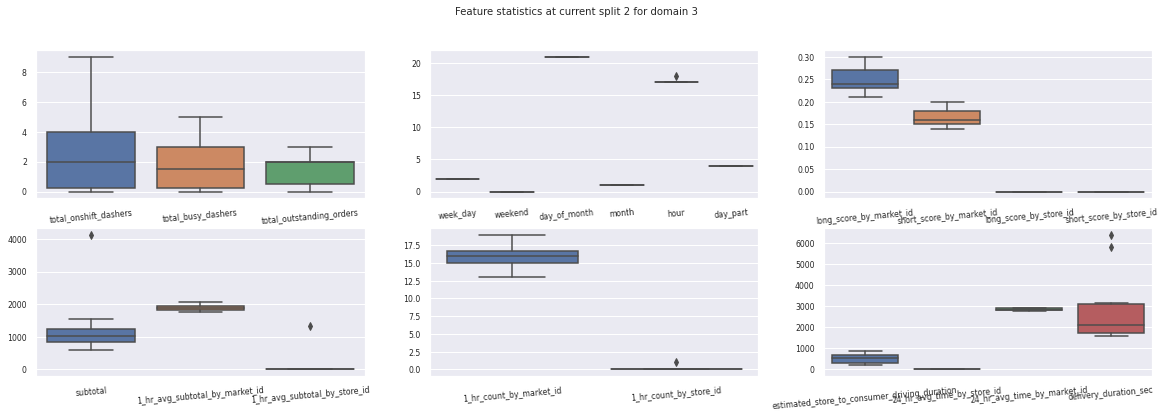

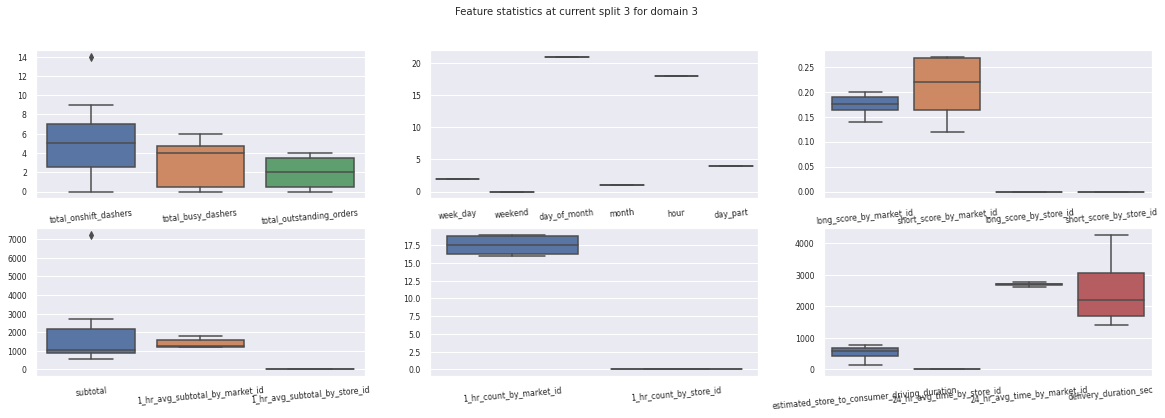

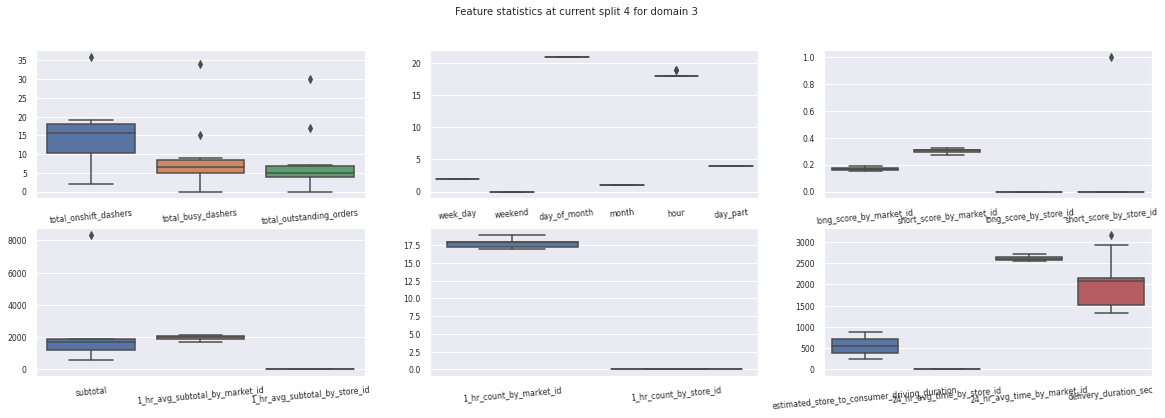

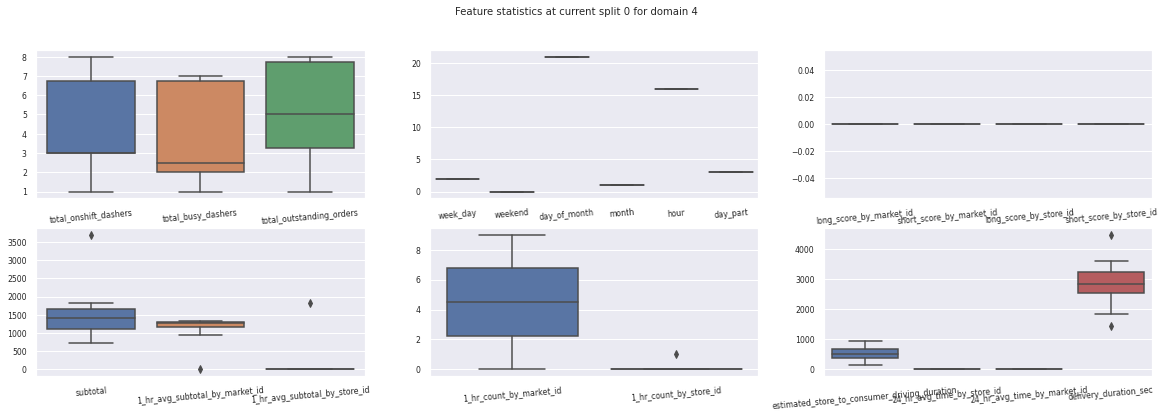

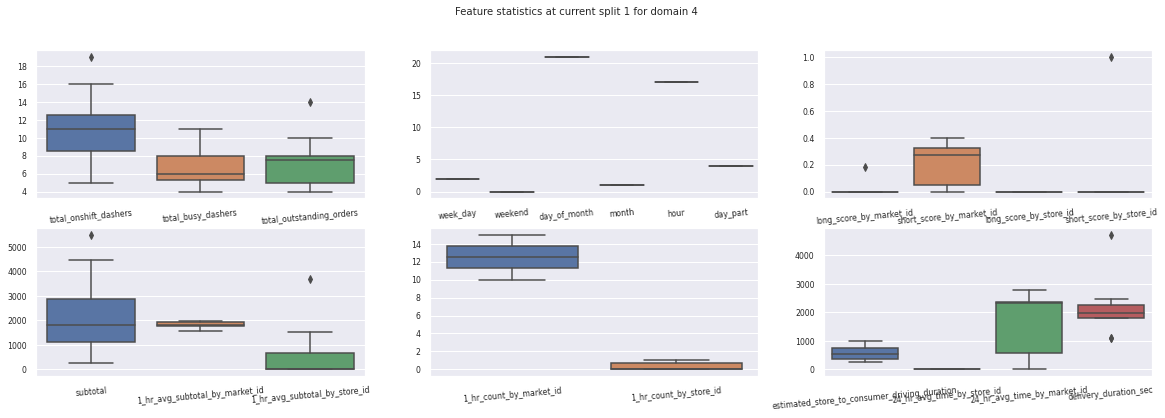

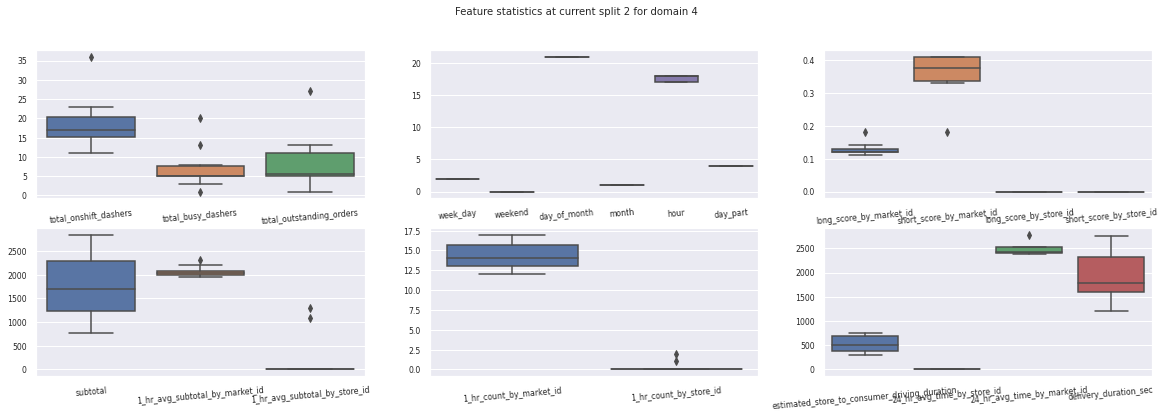

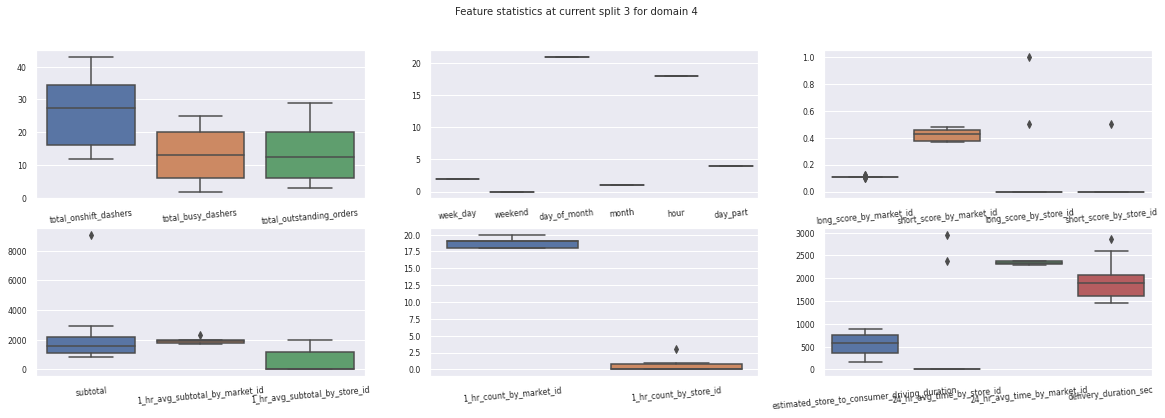

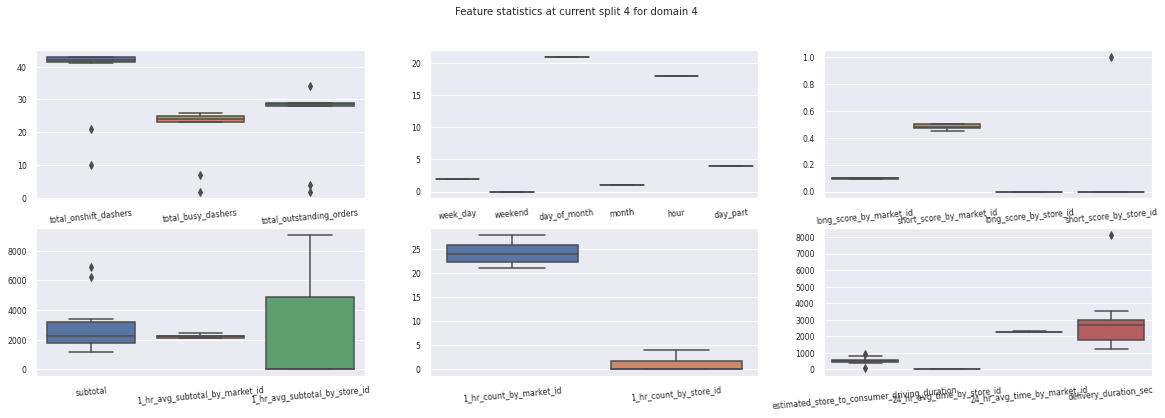

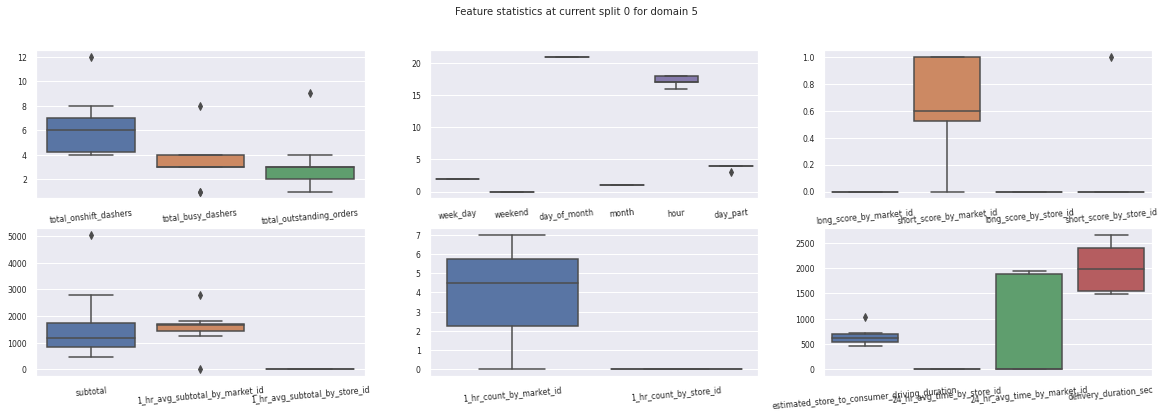

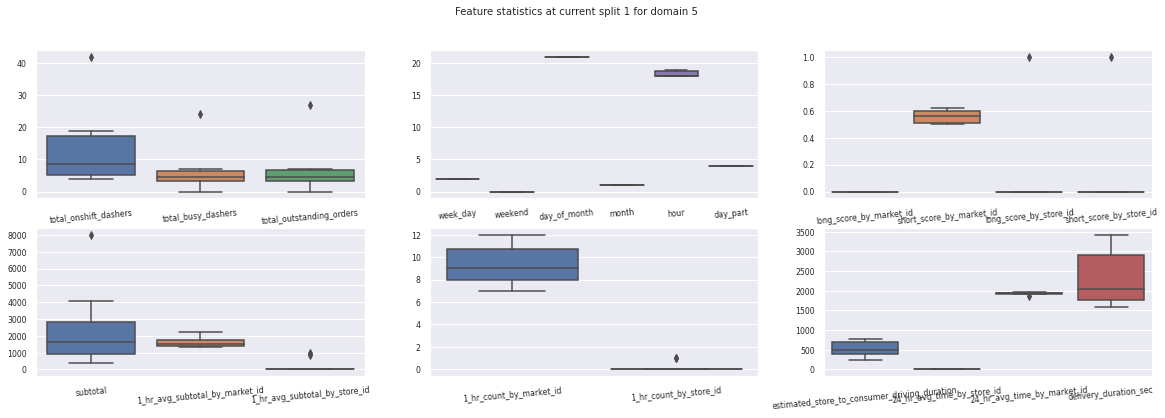

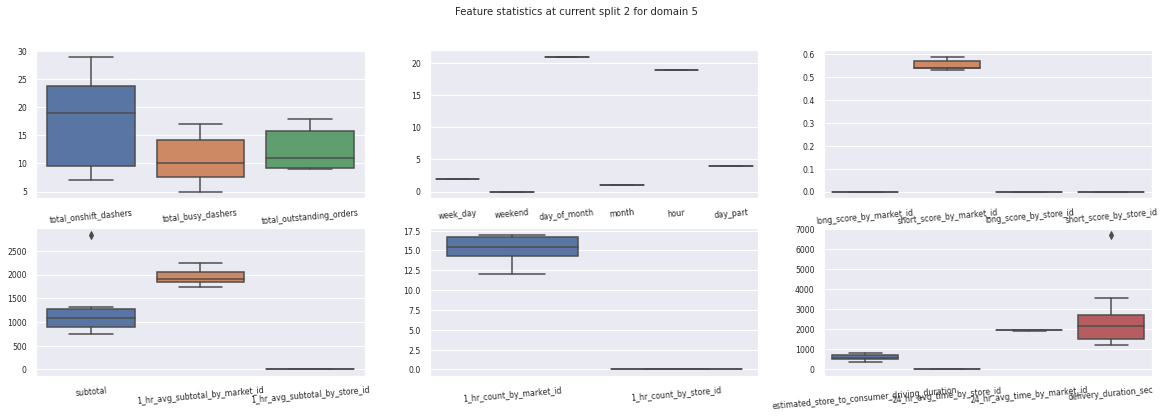

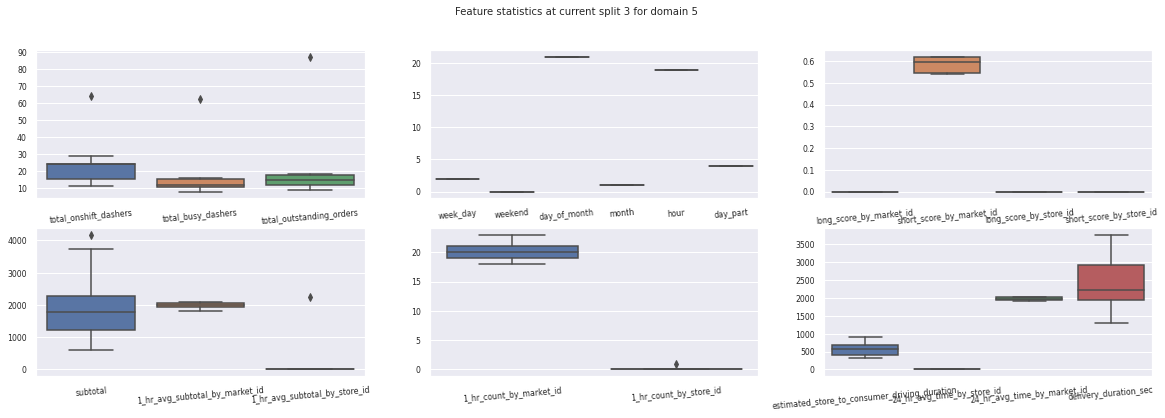

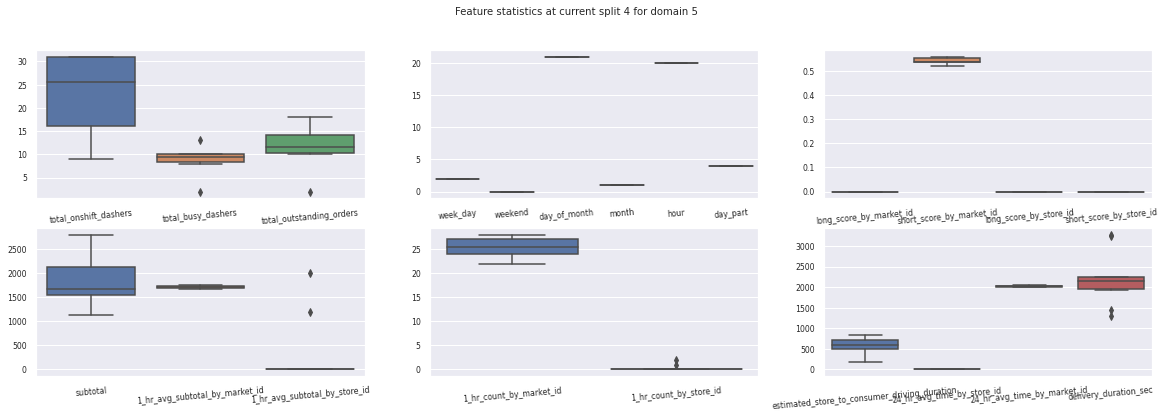

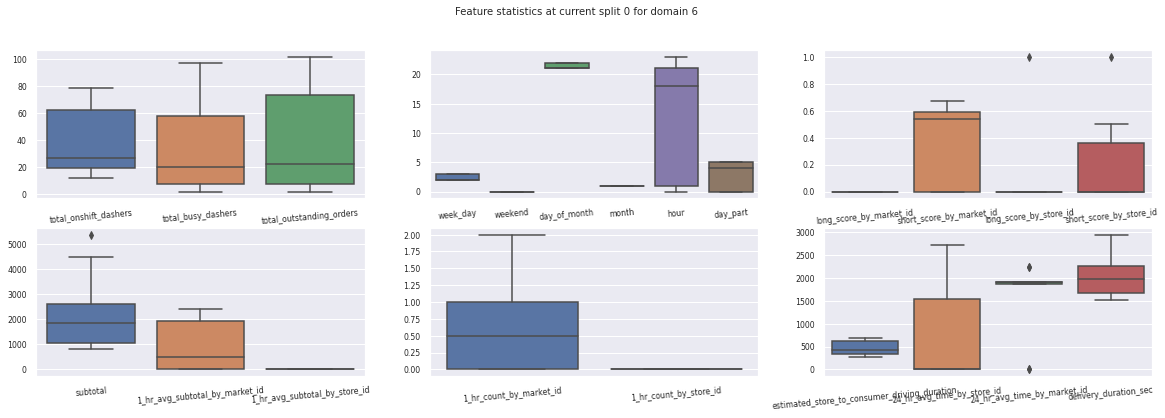

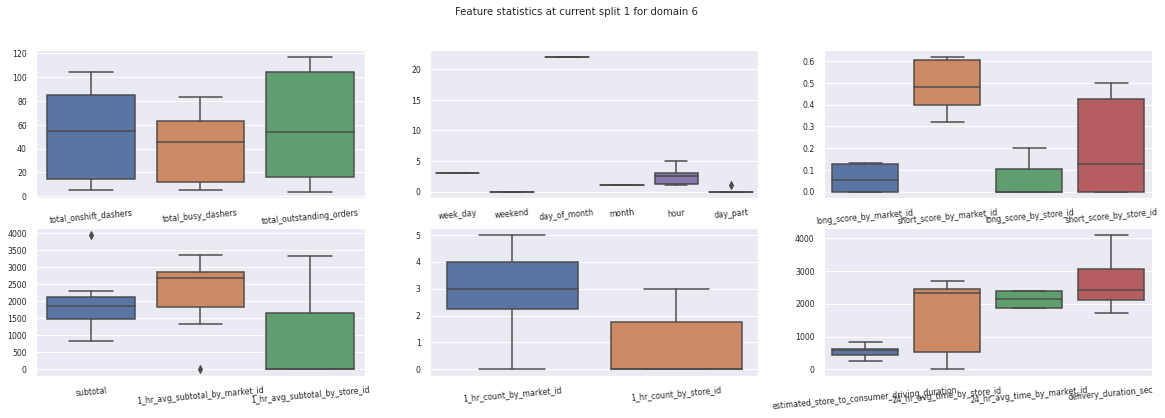

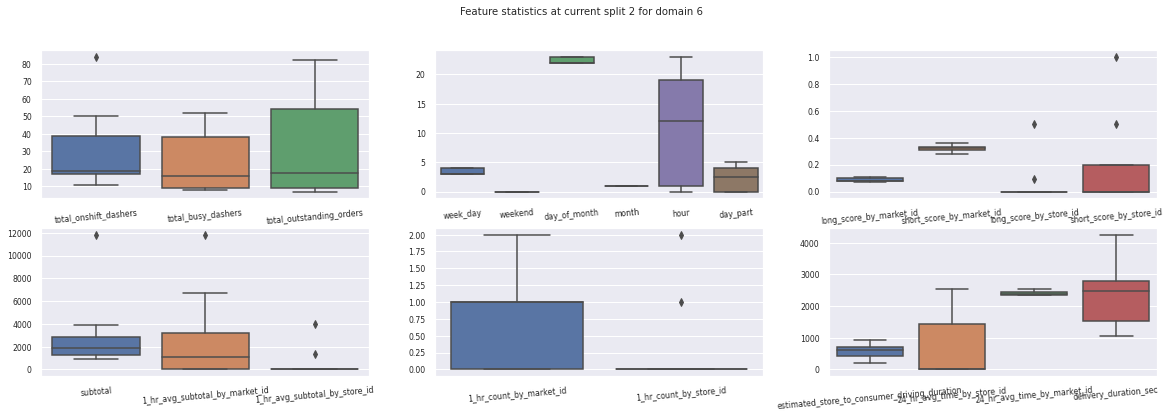

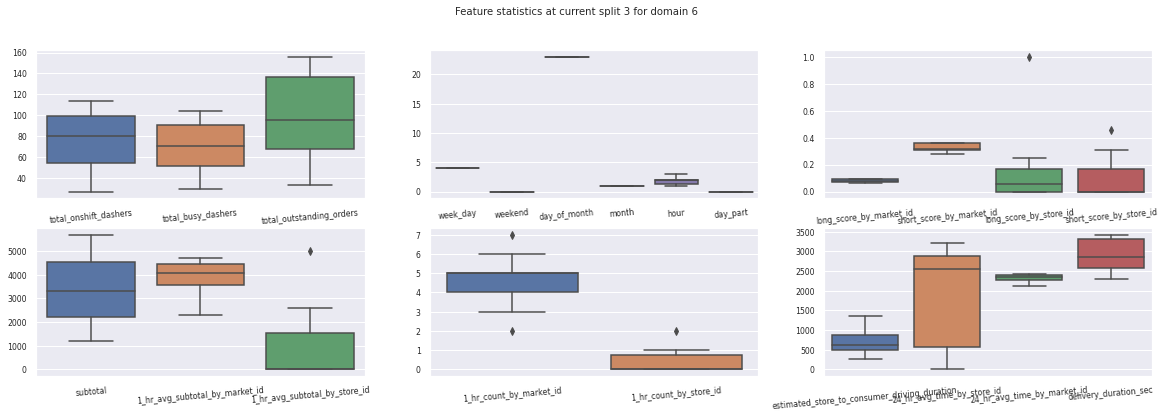

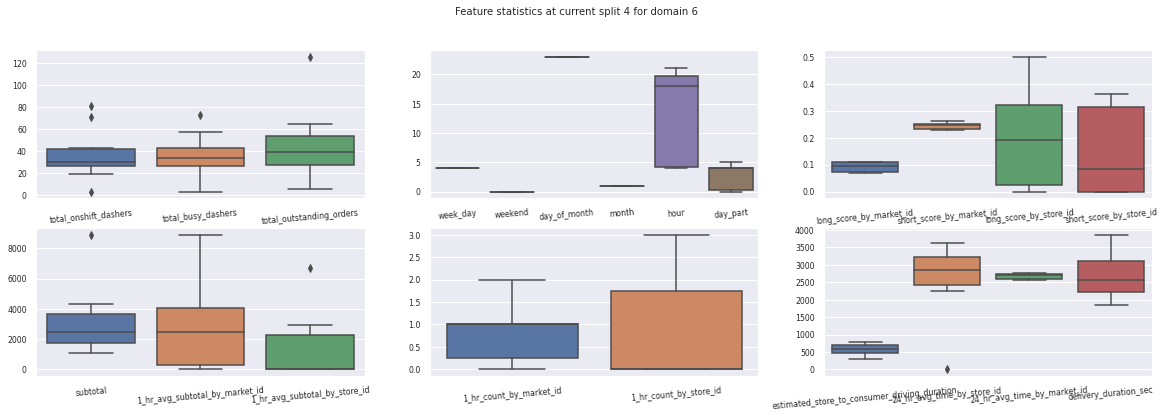

In [40]:
# variation of markets across time periods of 4-6 days on average (or the entire time period divided by p.n_folds)

df.sort_values(by=['created_at'], inplace=True)
domains = [df[df['market_id'] == v].sort_values(by=['created_at']) for v in sorted(df['market_id'].unique())]
names = ['created_at']
print(len(domains))
for _id, d in enumerate(domains):
    print("New Domain: {}".format(_id))
    d = d[:50] # reducing size due to notebook kernel issues 
    window_size = d.shape[0] / p.n_folds
    for i in range(p.n_folds):
        if 'delivery_duration_sec' in d.columns:
            y_d = d['delivery_duration_sec'].astype('int32').to_numpy()
        else:
            y_d = np.zeros((d.shape[0], 1))
        if 'actual_delivery_time' in d.columns:
            names += ['actual_delivery_time']
        # if 'delivery_duration_sec' in d.columns:
        #     names += 'delivery_duration_sec'
        print("start of slice {}: {}".format(i, d.iloc[int(i*window_size)]['created_at']))
        temp = d.drop(names, axis=1)
        
        
        x_d = temp.to_numpy()
        
        X_train, X_val, y_train, y_val = return_slice([x_d], [y_d], i)
        
        all_features = np.array([X_val[i,:] for i in range(X_val.shape[0])])
        fig, axes = plt.subplots(2, 3, figsize=(20, 6))
        fig.suptitle('Feature statistics at current split {} for domain {}'.format(i, _id+1))
        for y, b in enumerate(batches):
            indexes = [temp.columns.get_loc(column) for column in b]
            features = all_features[:, indexes]
            chart = sns.boxplot(ax=axes[y // 3, y % 3], data=features)
            chart.set_xticklabels(list(temp.columns[indexes]), rotation=5) 

we can see large variance over time for multiple features and even directly in the label. <br>
For example, the number of dashers and outstanding orders in the second period decrease which could indicate a slow market or supply
and also point again to the potential of detecting and targeting short/long tail orders. 


In [41]:
# variation across a random kfold
from sklearn.model_selection import RepeatedKFold
kf = RepeatedKFold(n_splits=p.n_folds, n_repeats=1,
                   random_state=12)
X_hist = df.to_numpy()
y_hist = df['delivery_duration_sec'].to_numpy()

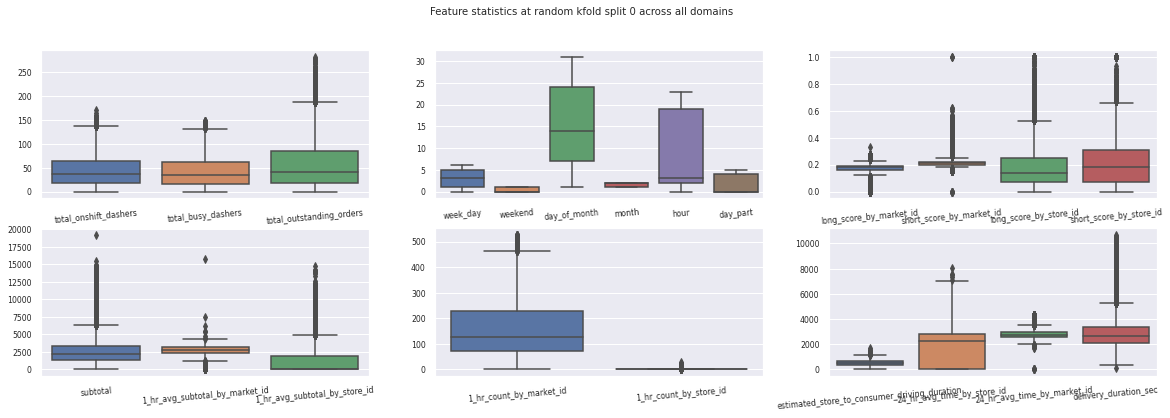

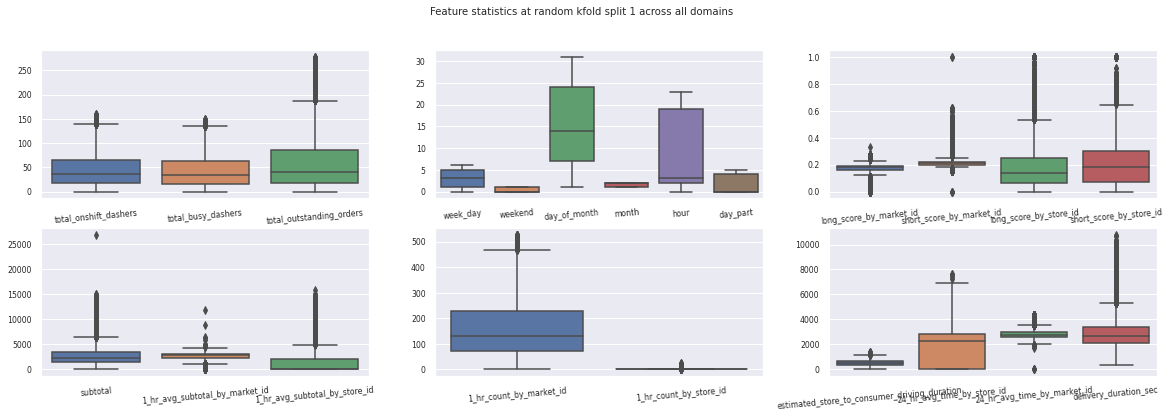

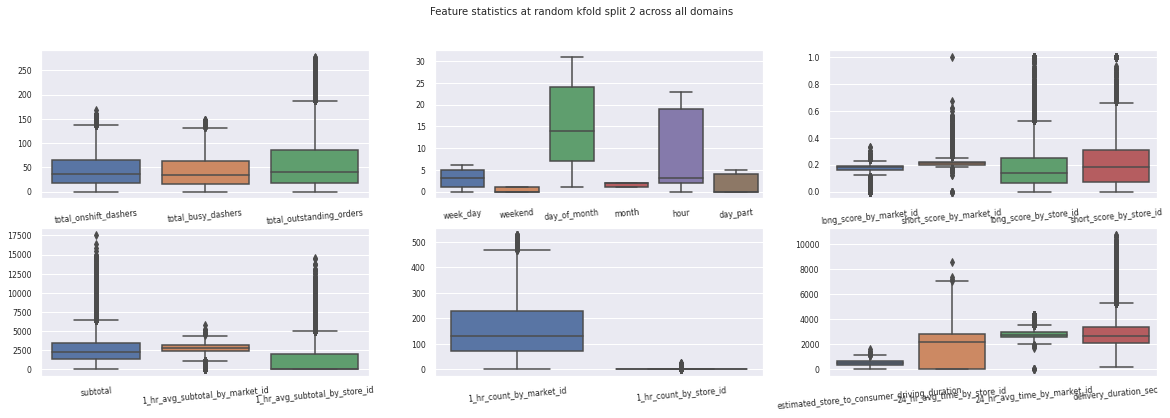

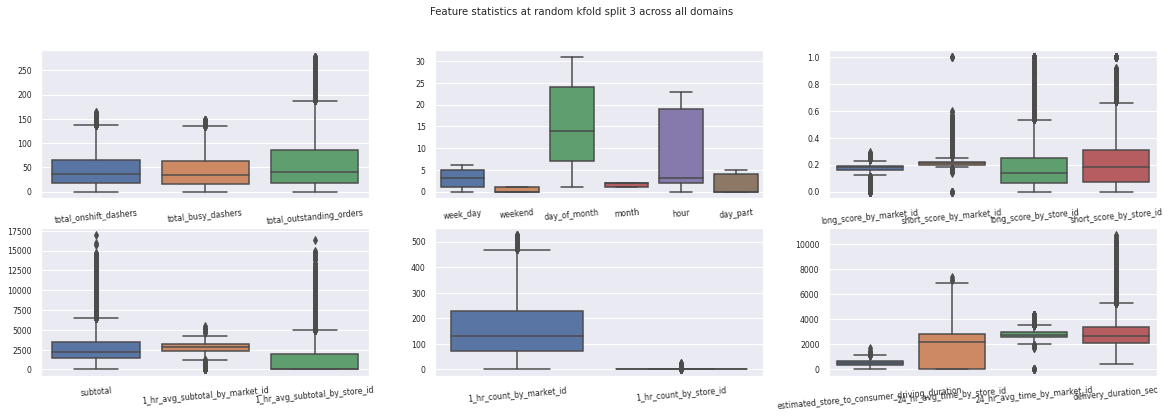

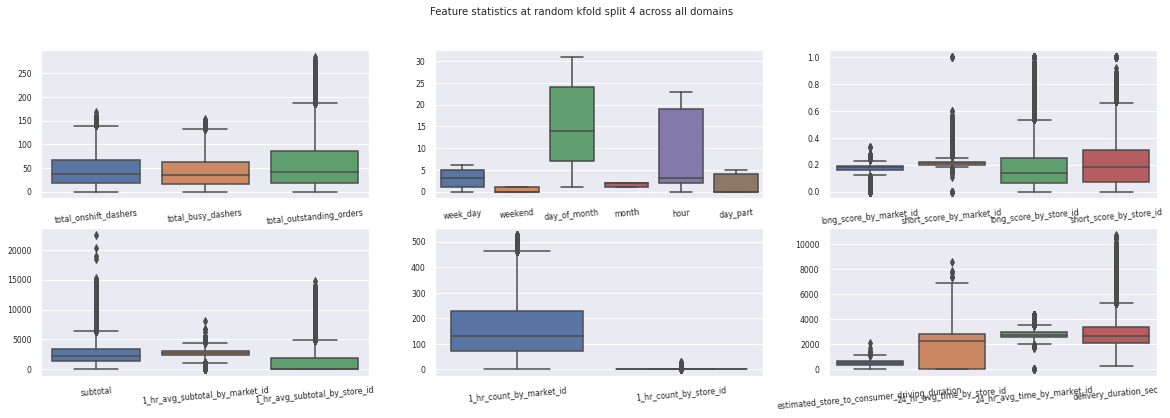

In [42]:
for i, (t, v) in enumerate(kf.split(X_hist)):
    X_train, X_val = X_hist[t], X_hist[v]
    # y_train, y_val = y_hist[t], y_hist[v]
    
    all_features = np.array([X_val[i,:] for i in range(X_val.shape[0])])
    fig, axes = plt.subplots(2, 3, figsize=(20, 6))
    fig.suptitle('Feature statistics at random kfold split {} across all domains'.format(i))
    for y, b in enumerate(batches):
        indexes = [df.columns.get_loc(column) for column in b]
        features = all_features[:, indexes]
        chart = sns.boxplot(ax=axes[y // 3, y % 3], data=features)
        chart.set_xticklabels(list(df.columns[indexes]), rotation=5) 

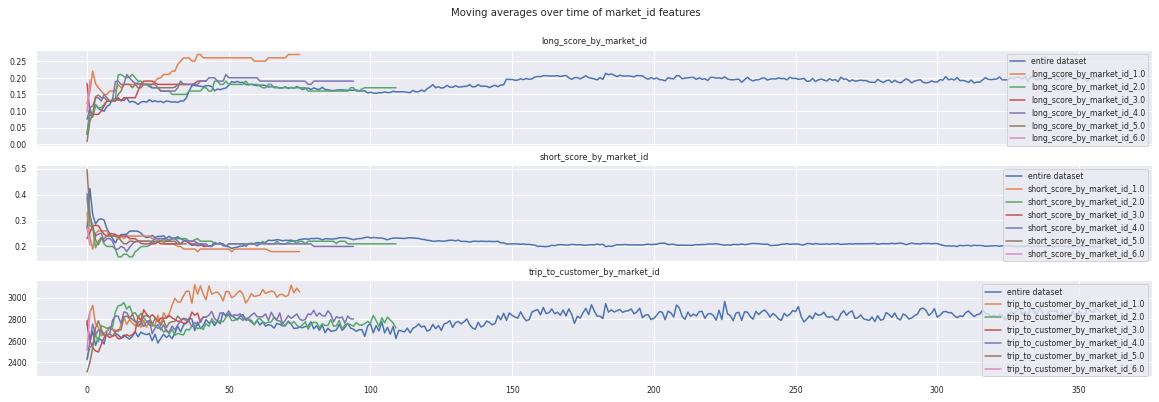

In [43]:
# check how long/short evolve over time

fig, axes = plt.subplots(3, 1, figsize=(20, 6),  sharex=True)
fig.suptitle('Moving averages over time of market_id features')
window = 100
step = 500
features = ['long_score_by_market_id', 'short_score_by_market_id', 'trip_to_customer_by_market_id']
moving_average_feature = 'market_id'
for i, feature in enumerate(features):
    df.sort_values(by=['created_at'], inplace=True)
    df = df.reset_index(drop=True)
    # plt.title('Moving average of {} with window={} and step={}'.format(feature, window, step))
    rolled = apply_rolling_data(df, col=feature, function=np.mean, window=window,step=step)
    axes[i].plot(range(len(rolled)), rolled, label='entire dataset')
    axes[i].set_title(feature)
    for v in sorted(df[moving_average_feature].unique()):
        # reduces search space to same domain value
        # print(v)
        l = "{}_{}".format(feature, v)
        # print(l)
        domain_df = df.loc[df[moving_average_feature] == v]
        domain_df.sort_values(by=['created_at'], ascending=[True], inplace=True)
        # print(domain_df.shape)
        rolled = apply_rolling_data(domain_df, col=feature, function=np.mean, window=window,step=step)
        axes[i].plot(range(len(rolled)), rolled, label=l)
        axes[i].legend(loc='best')

# Linear Regression 

In [44]:
# Linear Regression (historical only)X = sub_df.loc[:, ['estimated_store_to_consumer_driving_duration']].to_numpy().reshape(-1, 1)from sklearn import linear_model
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
np.set_printoptions(precision=4)
np.set_printoptions(suppress=False)
if 'actual_delivery_time' in df.columns:
    temp = df
    temp = temp.drop(columns=['created_at', 'actual_delivery_time', 'delivery_duration_sec'])
    X_hist = temp.to_numpy()
    X_hist = X_hist
    # y_hist = y_hist
    # print(X_hist.shape)
    # print(y_hist.shape)
    regr = linear_model.LinearRegression()
    regr = regr.fit(X_hist, y_hist)
    y_pred = regr.predict(X_hist)
    mae = mean_absolute_error(y_hist, y_pred)
    print("mae: {}".format(mae))
    print("coefficients")
    p = regr.coef_.argsort()
    for ordered_i in p:
        print("{} : {}".format(temp.columns[ordered_i],regr.coef_[ordered_i]))

mae: 667.5166305924523
coefficients
long_score_by_market_id : -2125.283059724498
short_score_by_store_id : -507.17739373024637
month : -92.47061925168131
day_part : -85.9097198954484
week_day : -24.08573714335605
total_onshift_dashers : -19.847135089866356
market_id : -8.110311472440543
total_busy_dashers : -7.654689651577882
day_of_month : -5.045969211926929
24_hr_avg_time_by_store_id : -0.016320831813195373
store_id : -0.004188143974506231
trip_to_customer_by_store_id : 0.002184558531999191
1_hr_avg_subtotal_by_store_id : 0.0023559984249731936
subtotal : 0.08368782506526344
1_hr_avg_subtotal_by_market_id : 0.21862263472152899
estimated_store_to_consumer_driving_duration : 0.23041625388224135
24_hr_avg_time_by_market_id : 0.24721233188962885
trip_to_customer_by_market_id : 0.696471867208778
1_hr_count_by_market_id : 1.3558850169653567
total_outstanding_orders : 16.276614183274823
1_hr_count_by_store_id : 16.724030374393617
hour : 17.996111551599764
weekend : 92.57018486661087
long_sco

# Results

In [45]:
# results for train/val on historical data with different tasks, parameters and number of features
# code: task_id.stacking_length.n_features
logs_root = '../logs/'
cache_root = '../cache/'
jobs = [('_78__lossweight_1.out', '1.3.26 (Best solution)'), ('_84_2.out', '2.3.26'), ('_83_1a.out', '1.1.25')]
for (job_path, bio) in jobs:
    path = os.path.join(logs_root, job_path)
    with open(path) as f:
        kfold_logs = f.readlines() [-12:]
        print('Job {} with the following validation metrics\n'.format(bio))
        for l in kfold_logs:
            print(l)
# read logs for kfold metrics

Job 1.3.26 (Best solution) with the following validation metrics

mean_absolute_error mean: 636.0216064453125

mean_absolute_error std: 36.684486389160156

mean_absolute_error max: 700.0360717773438

mean_absolute_error min: 593.3677368164062

lateness mean: 0.21516278386116028

lateness std: 0.015502294525504112

lateness max: 0.23107792437076569

lateness min: 0.18821203708648682

earliness mean: 0.19290393590927124

earliness std: 0.013224944472312927

earliness max: 0.2158033698797226

earliness min: 0.18179531395435333

Job 2.3.26 with the following validation metrics

mean_absolute_error mean: 645.1043090820312

mean_absolute_error std: 33.323551177978516

mean_absolute_error max: 700.7145385742188

mean_absolute_error min: 596.859130859375

lateness mean: 0.22363027930259705

lateness std: 0.012780275195837021

lateness max: 0.2387237846851349

lateness min: 0.20535001158714294

earliness mean: 0.18907789885997772

earliness std: 0.018430281430482864

earliness max: 0.2205508351

In [46]:
# result for test results with different tasks, parameters and number of features
jobs = [('_predict_2__writing_new_test_v4.out', '1.3.23', 'final_predict_2'),('_predict_3_1b2.out', '1.3.17', 'final_predict_3'),
        ('_predict_4_1a_2.out', '1.1.17', 'final_predict_4'), ('_predict_5_task_2_nfeatures_2.out', '2.3.17', 'final_predict_5')] 
test_predictions =  pd.DataFrame()

for (job_path, bio, cache_path) in jobs:
    path = os.path.join(logs_root, job_path)
    with open(path) as f:
        kfold_logs = f.readlines() [-5:-1]
        print('Job {} with the following train metrics\n'.format(bio))
        results = pd.read_csv(os.path.join(cache_root, cache_path, '0/results.txt'), names=['delivery_id',bio])
        if not 'delivery_id' in test_predictions.columns:
            test_predictions['delivery_id'] = results['delivery_id']
        # test_predictions[bio] = test_predictions.delivery_id.map(results.set_index('delivery_id')[bio])
        test_predictions = pd.merge(test_predictions, results, on='delivery_id')
        # test_predictions[bio] = results[bio]
        # test_predictions[bio] = 
        for l in kfold_logs:
            print(l)
print(test_predictions)


Job 1.3.23 with the following train metrics

Best value of tracked metric: 618.0305786132812

Best mean_absolute_error: 618.0305786132812

Best lateness: 0.18716344237327576

Best earliness: 0.21749764680862427

Job 1.3.17 with the following train metrics

Best value of tracked metric: 654.2315673828125

Best mean_absolute_error: 654.2315673828125

Best lateness: 0.19749963283538818

Best earliness: 0.23832295835018158

Job 1.1.17 with the following train metrics

Best value of tracked metric: 671.3914184570312

Best mean_absolute_error: 671.3914184570312

Best lateness: 0.20873555541038513

Best earliness: 0.2363593429327011

Job 2.3.17 with the following train metrics

Best value of tracked metric: 650.8883666992188

Best mean_absolute_error: 650.8883666992188

Best lateness: 0.19638481736183167

Best earliness: 0.23636479675769806

       delivery_id   1.3.23   1.3.17   1.1.17   2.3.17
0            99834  2366.33  2689.34  2822.63  2276.11
1            34717  2580.94  3260.79  2872.

0         90.22
1        -71.83
2        717.58
3        721.38
4        241.83
          ...  
50184    329.46
50185      6.63
50186     81.48
50187    185.84
50188    452.62
Length: 50189, dtype: float64


<AxesSubplot:>

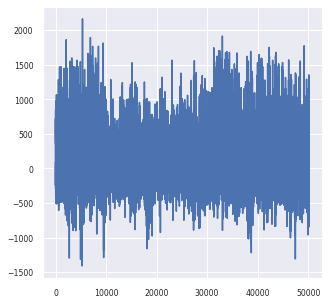

In [47]:
# drift

drift = (test_predictions['1.3.23'] - test_predictions['2.3.17'])
print(drift)
drift.plot(figsize=(5,5))

<AxesSubplot:>

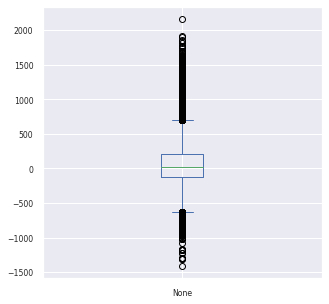

In [48]:
drift.plot.box(figsize=(5,5))